**MITx 6.419x  Data Analysis: Statistical Modeling and Computation in Applications**  
Written report -- Homework 4  
Xing Zhang  
5/14/21  
---

## Module 4: Time Series

### Problem 2: The Mauna Loa CO<sub>2</sub> Concentration
### The final model

**1.** (3 points) Plot the periodic signal $P_i$. (Your plot should have 1 data point for each month, so 12 in total.) Clearly state the definition the $P_i$, and make sure your plot is clearly labeled.
>Python tip: For interpolation, you may use interp1d from Scikit-learn. See Documentation on interp1d.

### Solution:
In this problem, it has been assumed that the time period is 12 (which seems to be valid as CO2 concentration is linked to seasonal variation.) First we extract the periodic monthly trend by taking the average of the periodic trend over all months. Next, we interpolate between this values to get a continuous periodic signal.

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
# import pmdarima as pm

import math
# import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

# Initialize columns of dataframe
cols = [
    "year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"
]
keep_cols = ["year", "month", "co2"]
co2 = (
    pd.read_csv("CO2.csv", skiprows=57, header=None, names=cols)
    .drop(columns=[col for col in cols if col not in keep_cols]) # Only keep column 5 and date columns
    .assign(co2=lambda df: df.co2.replace({-99.99: np.nan})) # -99.99 indicates a homogeneity - replace it with null
    .assign(time=lambda df: (df.index.values + 0.5) / 12) # Convert to time notation that question specifies
)

co2 = co2.dropna() # drop missing values from the dataframe
x = list(chain.from_iterable(co2.time.values[..., None])) 
y = list(chain.from_iterable(co2.co2.values[..., None])) 

train_size = int(len(x)*0.8)
gap = 0 # int(len(x)*0.1)
test_size = len(x) - train_size - gap
x_train = x[0:train_size]
y_train = y[0:train_size]
x_test = x[train_size + gap: None]
y_test = y[train_size + gap: None]
co2_test = co2.iloc[train_size + gap: None,:].copy()
co2_train = co2.iloc[0:train_size,:].copy()

degree=2
model_2=make_pipeline(PolynomialFeatures(degree),LinearRegression())
model_2.fit(np.array(x_train).reshape(-1, 1),y_train)
quadratic = model_2.predict(np.array(x_train).reshape(-1, 1))

co2_train["R_quad"] = y_train - quadratic
co2_train.head(5)

month_mean_res = co2_train.groupby("month").R_quad.mean()
month_continuous = np.linspace(1,12,num = 100, endpoint =True)
periodic= interp1d(month_mean_res.index,month_mean_res.values,kind = 'cubic')
p = figure(plot_width=400, plot_height=400, title = "Periodic Signal")
p.scatter(month_mean_res.index,month_mean_res.values,size=6, line_color="navy", fill_color="green", fill_alpha=0.5,legend_label ='Periodic Values')
p.line(month_continuous,periodic(month_continuous),line_color="navy",line_width =2.5,legend_label ='Periodic Signal')
show(p)
# print(month_mean_res)




Loading BokehJS ...

**2.** (2 points) Plot the final fit $F_n(t_i)+P_i$. Your plot should clearly show the final model on top of the entire time series, while indicating the split between the training and testing data.

### Solution:
First, time of P_i  need to be normalized to the global time to match the time of F; then we modify P_i into a continuous function in the interval[0,1], and finally we superimpose P_i and F to get the final fit.

In [22]:
month_mean_res = co2_train.groupby("month").R_quad.mean()
month_mean_res_smooth = [-0.921507, -0.012919, 0.646407, 1.355569, 2.561858, 2.982891, 2.316473, 0.776297, -1.301213, -3.128074, -3.309520,\
                         -2.081487, -0.921507, -0.012919]
time_month = [-0.5/12, 0.5/12,1.5/12, 2.5/12, 3.5/ 12, 4.5/12, 5.5/12, 6.5/12, 7.5/12, 8.5/12, 9.5/12, 10.5/12, 11.5/12,12.5/12]
month_continuous1 = np.linspace(-0.5/12,12.5/12,num = 100, endpoint =True)
periodic1= interp1d(time_month,month_mean_res_smooth,kind = 'cubic')
p1 = figure(plot_width=400, plot_height=400, title = "Periodic Signal")
p1.scatter(time_month,month_mean_res_smooth,size=6, line_color="navy", fill_color="green", fill_alpha=0.5,legend_label ='Periodic Values')
p1.line(month_continuous1,periodic1(month_continuous1),line_color="navy",line_width =2.5,legend_label ='Periodic Signal')
show(p1)

In [23]:
month_mean_res = co2_train.groupby("month").R_quad.mean()
month_mean_res_smooth = [-0.921507, -0.012919, 0.646407, 1.355569, 2.561858, 2.982891, 2.316473, 0.776297, -1.301213, -3.128074, -3.309520,\
                         -2.081487, -0.921507, -0.012919]
time_month = [-0.5/12, 0.5/12,1.5/12, 2.5/12, 3.5/ 12, 4.5/12, 5.5/12, 6.5/12, 7.5/12, 8.5/12, 9.5/12, 10.5/12, 11.5/12,12.5/12]
month_continuous = np.linspace(-0.5/12,12.5/12,num = 100, endpoint =True)
periodic= interp1d(time_month,month_mean_res_smooth,kind = 'cubic')

periodic_total = periodic((np.array(x_train)%1))
final = quadratic + periodic_total
p = figure(plot_width=400, plot_height=400, title = "C02 Variation with time")
p.scatter(x_train,y_train,size=2, line_color="red", fill_color="orange", fill_alpha=0.5, legend_label ="Train Data")
p.line(x_train,final, line_color="blue",line_width=2.5,legend_label ="Final Fit")
p.xaxis.axis_label ='t_i'
p.yaxis.axis_label ='CO2 Concentration'
p.legend.location = "top_left"
show(p)
quadratic_test = model_2.predict(np.array(x_test).reshape(-1, 1))
periodic_total_test = periodic((np.array(x_test)%1))
final_test = quadratic_test + periodic_total_test
p2 = figure(plot_width=400, plot_height=400, title = "C02 Variation with time")
p2.scatter(x_test,y_test,size=2, line_color="navy", fill_color="orange", fill_alpha=0.5, legend_label ="Test Data")
p2.line(x_test,final_test, line_color="orange",line_width=2.5,legend_label ="Final Fit Model Predictions")
p2.legend.location = "top_left"
show(p2)

p3 = figure(plot_width=400, plot_height=400, title = "Residuals")
p3.scatter(x_train,y_train - final ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="R_train")
p3.yaxis.axis_label ='Residual'
p3.legend.location = "top_left"
show(p3)

p4 = figure(plot_width=400, plot_height=400, title = "Residuals")
p4.scatter(x_test,y_test - final_test ,size=2, line_color="navy", fill_color="blue", fill_alpha=0.5, legend_label ="R_test")
p4.yaxis.axis_label ='Residual'
p4.legend.location = "top_left"
show(p4)

In train data fit, R value is vibration within a certain range. In test data fit, R value shows an increasing trend with time growth. This means that the growth rate of CO2 concentration began to increase after 2000.

**3.** (4 points) Report the root mean squared prediction error RMSE and the mean absolute percentage error MAPE with respect to the test set for this final model. Is this an improvement over the previous model $F_n(t_i)$ without the periodic signal? (Maximum 200 words.)

In [17]:
rmse_final_test = (mean_squared_error(y_test, final_test))**0.5
mape_final_test = mean_absolute_percentage_error(y_test, final_test)

print("The mean squared prediction error of the Final Fit model is " + str(rmse_final_test))
print("The mean absolute percentage error of the Final Fit model is " + str(mape_final_test))

The mean squared prediction error of the Final Fit model is 1.1493602596634225
The mean absolute percentage error of the Final Fit model is 0.20859165685936393


### Solution:
The mean squared prediction error of the Final Fit model is 1.1493602596634225\
The mean absolute percentage error of the Final Fit model is 0.20859165685936393

Compare to the previous analysis：
>The mean squared prediction error of the trend model is 2.5013322194898326 \
>The mean absolute percentage error of the trend model is 0.5320319129740952

So that the final model improved a lot over the previous model $F_n(t_i)$ without the periodic signal.

**4.** (3 points) What is the ratio of the range of values of $F$ to the amplitude of $P_i$ and the ratio of the amplitude of $P$ to the range of the residual $R_i$ (from removing both the trend and the periodic signal)? Is this decomposition of the variation of the CO2 concentration meaningful? (Maximum 200 words.)

In [8]:
F = model_2.predict(np.array(x).reshape(-1, 1))
periodic_total = periodic((np.array(x)%1))
final_total = F + periodic_total
R = y - final_total
final_total_range = final_total.max() - final_total.min()
periodic_total_range = periodic_total.max() - periodic_total.min()
R_range = R.max() - R.min()
ratio_F = final_total_range/periodic_total_range
ratio_P = periodic_total_range/R_range

mape_final_test = mean_absolute_percentage_error(y_test, final_test)

print("The ratio of the range of values of $F$ to the amplitude of $P_i$ is " + str(ratio_F))
print("The ratio of the amplitude of $P$ to the range of the residual $R_i$ is " + str(ratio_P))

The ratio of the range of values of $F$ to the amplitude of $P_i$ is 15.95743409659297
The ratio of the amplitude of $P$ to the range of the residual $R_i$ is 1.3341427263860355


### Solution:
The ratio of the range of values of $F$ to the amplitude of $P_i$ is 15.95743409659297\
The ratio of the amplitude of $P$ to the range of the residual $R_i$ is 1.3341427263860355

We know that:
>The decomposition is meaningful only if the range of $F$ is much larger than the amplitude of the $P_i$ and this amplitude in turn is substantially larger than that of $R_i$.

So in this case, the decomposition is meaningful.

### Problem 3: Autocovariance Functions

**1.** (4 points) Consider the MA(1) model,

$$X_t = W_t + \theta W_{t-1},$$

where $W_t\sim W\sim\mathcal{N}(0,\sigma^2)$. Find the autocovariance function of $X_t$.
Include all important steps of your computations in your report.

### Solution

Suppose that $\left\{X_{t}\right\}$ is a time series with $\mathrm{E}\left[X_{t}^{2}\right]<\infty$ Its mean function is
$$
\mu_{t}=\mathrm{E}\left[X_{t}\right]
$$
Its autocovariance function is
$$
\begin{aligned}
\gamma_{X}(s, t) &=\operatorname{Cov}\left(X_{s}, X_{t}\right) \\
&=\mathrm{E}\left[\left(X_{s}-\mu_{s}\right)\left(X_{t}-\mu_{t}\right)\right]
\end{aligned}
$$

In this case

$$X_t = W_t + \theta W_{t-1},$$

where $W_t\sim W\sim\mathcal{N}(0,\sigma^2)$. So that,

We have $\mathrm{E}\left[X_{t}\right]=0$,   $\mathrm{E}\left[W_{t}^{2}\right]=\sigma^{2}$,  $\mathrm{E}\left[\theta^{2}W_{t-1}^{2}\right]=\theta^{2} \sigma^{2}$,   $\mathrm{E}\left[W_{t}W_{t-1}\right]=0$

so we got autocovariance function:
$$
\begin{aligned}
\gamma_{X}(t+h, t) &=\mathrm{E}\left(X_{t+h} X_{t}\right) \\
&=\mathrm{E}\left[\left(W_{t+h}+\theta W_{t+h-1}\right)\left(W_{t}+\theta W_{t-1}\right)\right] \\
&=\left\{\begin{array}{ll}
\sigma^{2}\left(1+\theta^{2}\right) & \text { if } h=0, \\
\sigma^{2} \theta & \text { if } h=\pm 1 \\
0 & \text { otherwise }
\end{array}\right.
\end{aligned}
$$

**2.** (4 points) Consider the AR(1) model,

$$X_t=\phi X_{t-1}+W_t,$$

where $W\sim W_t\sim\mathcal{N}(0,\sigma^2)$. Suppose $|\phi|<1$. Find the autocovariance function of ${X_t}$. (You may use, without proving, the fact that ${X_t}$ is stationary if $|\phi|<1$.)  
Include all important steps of your computations in your report.

### Solution

Suppose that $\left\{X_{t}\right\}$ is a time series with $\mathrm{E}\left[X_{t}^{2}\right]<\infty$ Its mean function is
$$
\mu_{t}=\mathrm{E}\left[X_{t}\right]
$$
Its autocovariance function is
$$
\begin{aligned}
\gamma_{X}(s, t) &=\operatorname{Cov}\left(X_{s}, X_{t}\right) \\
&=\mathrm{E}\left[\left(X_{s}-\mu_{s}\right)\left(X_{t}-\mu_{t}\right)\right]
\end{aligned}
$$

In this case

$$X_t=\phi X_{t-1}+W_t,$$

where $W\sim W_t\sim\mathcal{N}(0,\sigma^2)$. Suppose $|\phi|<1$.  Then we have
$$
\begin{aligned}
\mathrm{E}\left[X_{t}\right] &=\phi \mathrm{E}\left[X_{t-1}\right]\\
&=0 \quad 
\end{aligned}
$$

$$
\begin{aligned}
\mathrm{E}\left[X_{t}^{2}\right] &=\phi^{2} \mathrm{E}\left[X_{t-1}^{2}\right]+\sigma^{2} \\
&=\frac{\sigma^{2}}{1-\phi^{2}}
\end{aligned}
$$

so we got autocovariance function:
$$
\begin{array}{l}
\begin{aligned}
\gamma_{X}(h) &=\operatorname{Cov}\left(\phi X_{t+h-1}+W_{t+h}, X_{t}\right) \\
&=\phi \operatorname{Cov}\left(X_{t+h-1}, X_{t}\right) \\
&=\phi \gamma_{X}(h-1)\\ 
&=\phi^{|h|} \gamma_{X}(0) \quad \text { (check for } h>0 \text { and } h<0) \\
&=\frac{\phi^{|h|} \sigma^{2}}{1-\phi^{2}} 
\end{aligned}\\
\end{array}
$$

### Problem 5: Converting to Inflation Rates
### Inflation Rate from CPI

**1.** Repeat the model fitting and evaluation procedure from the previous page for the monthly inflation rate computed from CPI.  Your response should include:

- (1 point) Description of how you compute the monthly inflation rate from CPI and a plot of the monthly inflation rate.  
- (2 points) Description of how the data has been detrended and a plot of the detrended data. (You may choose to work with log of the CPI for later convenience.)  
- (3 points) Statement of and justification for the chosen AR($p$) model. Include plots and reasoning.  
- (3 points) Description of the final model; computation and plots of the 1 month-ahead forecasts for the validation data. In your plot, overlay predictions on top of the data.

### Solution:
I compute the monthly inflation rate from CPI by:
$$
\mathrm{IR}_{t}=\ln \left(\mathrm{CPI}_{t}\right)-\ln \left(\mathrm{CPI}_{t-1}\right)
$$
where $t$ indexes the months.

Subtract the linear growth trend from CPI_IR to get the detrended data plot.

From the above PACF plot, we can see that the highest lag at which the plot extends beyond the statistically significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data.

Loading BokehJS ...

The linear trend is given by F(t) = 0.0055300123366067*t + (-0.06427097234449808)


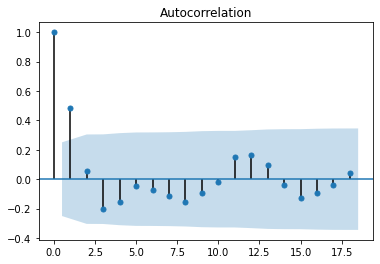

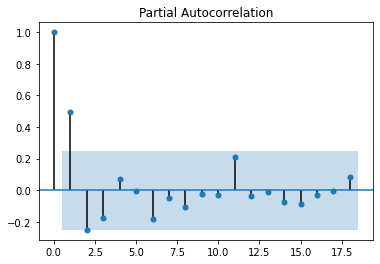

In [169]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
# import pmdarima as pm

import math
# import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

ps_cpi = pd.read_csv("PriceStats_CPI.csv")
ps_cpi['date'] =pd.to_datetime(ps_cpi['date'])
ps_cpi['YearMonth'] = ps_cpi['date'].dt.strftime('%Y-%m')
cpi =ps_cpi.drop_duplicates('YearMonth', keep='last').copy().reset_index().drop(['index','PriceStats'],axis=1)

#calculate monthly inflation from CPI

val2=np.log(cpi.CPI).diff().values*100
cpi['diff_log'] = val2
cpi_ir_train = (cpi[cpi.YearMonth<'2013-09'].copy())
cpi_ir_test = (cpi[cpi.YearMonth >='2013-09'].copy())
model = LinearRegression().fit(np.array(cpi_ir_train['diff_log'].dropna().index).reshape(-1, 1),cpi_ir_train['diff_log'].dropna())
coefficients = [model.coef_[0],model.intercept_]
print("The linear trend is given by F(t) = " +str(coefficients[0])+"*t + (" +str(coefficients[1])+")")
linear_cpi_ir =model.predict(np.array(cpi_ir_train['diff_log'].dropna().index).reshape(-1, 1))
p = figure(plot_width=400, plot_height=400, title = "CPI_IR Time Series")
p.line(cpi_ir_train['diff_log'].dropna().index,cpi_ir_train['diff_log'].dropna(), line_color="navy", line_width=2, legend_label ="Original Data")
p.line(cpi_ir_train['diff_log'].dropna().index,linear_cpi_ir, line_color="orange",line_width=2.5,legend_label ="Linear Trend")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI_IR'
p.legend.location='bottom_right'
show(p)

remaining = cpi_ir_train['diff_log'].dropna() - linear_cpi_ir
linear_cpi_ir_test = model.predict(np.array(cpi_ir_test['diff_log'].dropna().index).reshape(-1, 1))
train = cpi_ir_train['diff_log'].dropna().index
remaining_test = cpi_ir_test['diff_log'].dropna() - linear_cpi_ir_test   

p = figure(plot_width=400, plot_height=400, title = "CPI_IR Time Series")
p.line(cpi_ir_train['diff_log'].dropna().index,remaining, line_color="navy", line_width=2, legend_label ="Detrended Data")
p.legend.location='bottom_right'
show(p)

plot_acf(remaining)
plt.show()
plot_pacf(remaining)
plt.show()



In [106]:
def rebuild_diffed(series, first_element_original,x,linear_trend):
    if x == 'linear':
        final = series + linear_trend
    else:
        cumsum = pd.Series(series).cumsum()
        final = np.exp(cumsum.fillna(0) + first_element_original)
        if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))
    return final

## Building AR (2) Model 
n = 2
AR2_model = AutoReg(remaining, lags= n).fit()# Here we have used the default value for the trend parameter
coef = AR2_model.params
# walk forward over time steps in test
past = remaining[len(remaining)-n:].values
past = [past[i] for i in range(len(past))]
test_predictions = list()
training_predictions = AR2_model.predict(start = train[0], end =train[-1])
for t in range(len(remaining_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = remaining_test.values[t]
    test_predictions.append(pred)
    past.append(obs)
final_training = (rebuild_diffed(training_predictions,np.log(cpi_ir_train['diff_log'].dropna()),'linear',linear_cpi_ir))
final_test = (rebuild_diffed(test_predictions,np.log(cpi_ir_train['diff_log'].dropna()),'linear',linear_cpi_ir_test))
# final = (rebuild_diffed(test_predictions,np.log(cpi_train.iloc[-1].CPI),'linear',linear_cpi_ir_test))

p = figure(plot_width=400, plot_height=400, title = "IR_t Time Series")
p.line(cpi_ir_train['diff_log'].dropna().index,cpi_ir_train['diff_log'].dropna(), line_color="navy", line_width=2, legend_label ="Training Data")
p.line(cpi_ir_train['diff_log'].dropna().index,final_training, line_color="orange",line_width=2.5,legend_label ="AR(2) Model")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='IR_t'
p.legend.location='bottom_right'
show(p)

p = figure(plot_width=400, plot_height=400, title = "IR_t Time Series")
p.line(cpi_ir_test['diff_log'].dropna().index,cpi_ir_test['diff_log'].dropna(), line_color="navy", line_width=2, legend_label ="Test Data")
p.line(cpi_ir_test['diff_log'].dropna().index,final_test, line_color="orange",line_width=2.5,legend_label ="AR(2) Model")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='IR_t'
p.legend.location='bottom_right'
show(p)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


**2.** (3 points) Which AR($p$) model gives the best predictions? Include a plot of the RSME against different lags $p$ for the model.

### Solution:
AR( 2 ) model gives the best predictions

In [170]:
rmse_train=[]
for n in range(1,8):
    model = AutoReg(remaining.dropna(), lags= n,trend='n')
    model_fit = model.fit()
    predictions=model_fit.predict()
    rmse=(mean_squared_error(remaining[n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

p = figure(plot_width=400, plot_height=400, title = "RMSE of AR Models of order n")
p.scatter(np.arange(1,8),rmse_train,size = 15, marker ="square", line_color="navy",fill_color="orange", fill_alpha =0.5, legend_label ="RMSE")
p.xaxis.axis_label ='n'
p.yaxis.axis_label ='RMSE'
p.legend.location='top_right'
show(p)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmode

**3.** (3 points) Overlay your estimates of monthly inflation rates and plot them on the same graph to compare. (There should be 4 lines, one for each dataset, plus the predictions) over time (months from September 2013 onward).

In [117]:
p = figure(plot_width=800, plot_height=400, title = "IR_t Time Series")
p.line(cpi_ir_train['diff_log'].index,cpi_ir_train['diff_log'].dropna(), line_color="navy", line_width=2, legend_label ="Training Data")
p.line(cpi_ir_test['diff_log'].index,cpi_ir_test['diff_log'].dropna(), line_color="green", line_width=2, legend_label ="Test Data")
p.line(cpi_ir_train.index,final_training, line_color="orange",line_width=2.5,legend_label ="Estimates Data(Train)")
p.line(cpi_ir_test.index,final_test, line_color="red",line_width=2.5,legend_label ="Estimates Data(Test)")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='IR_t'
p.legend.location='bottom_right'
show(p)

### Problem 6: External Regressors and Model Improvements
### External Regressors

**1.** (4 points) Include as external regressors monthly average PriceStats inflation rate data and monthly BER data. Use cross-correlation plots to find the lag between the following:
- CPI inflation rate and PriceStats inflation rate
- CPI and BER inflation rate.

### Solution:

Cross-correlation plots between CPI inflation rate and PriceStats inflation rate: we can get the lag = 1.

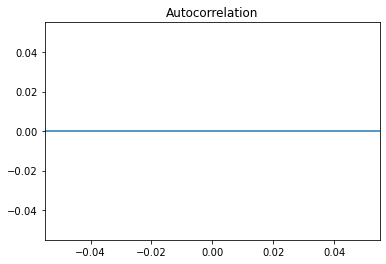

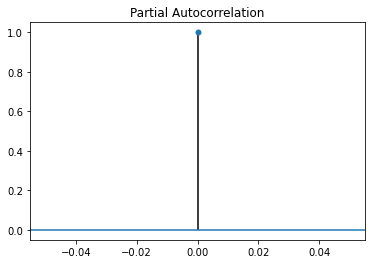

In [142]:
def calc_inflation_rate(data):
    ir = []
    for i in range(1,len(data)):
        ir_temp = (data[i]-data[i-1])/data[i-1] *100      
        ir.append(ir_temp)
#         print(i)
    return ir


ps_monthly = pd.DataFrame(columns =['YearMonth','PS'])
ps_monthly['PS'] =ps_cpi.groupby('YearMonth').PriceStats.mean().values
ps_monthly['YearMonth'] = cpi.YearMonth
val = calc_inflation_rate(ps_monthly.PS.values)
ps_monthly.loc[1:, 'IR_ps'] = val

ps_ir_train = (ps_monthly[ps_monthly.YearMonth<'2013-09'].copy())
ps_ir_test = (ps_monthly[ps_monthly.YearMonth >='2013-09'].copy())


remaining1 = cpi_ir_train['diff_log'] - ps_ir_train.IR_ps


plot_acf(remaining1)
plt.show()
plot_pacf(remaining1)
plt.show()

Cross-correlation plots between CPI and BER inflation rate: we can get the lag = 1.

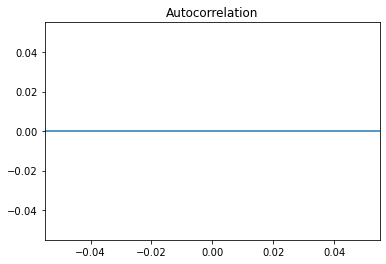

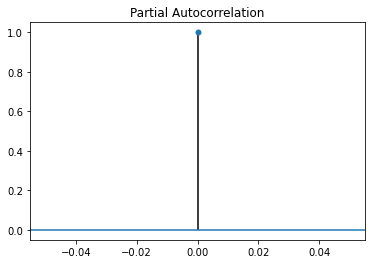

In [141]:

ber = pd.read_csv('T10YIE.csv')
ber['DATE'] =pd.to_datetime(ber['DATE'])
ber['YearMonth'] = ber['DATE'].dt.strftime('%Y-%m')
ber = ber.drop(ber[ber.YearMonth< '2008-07'].index)
ber = ber.dropna()
# print(ber)

ber_monthly = pd.DataFrame(columns =['YearMonth','BER'])
ber_monthly['BER'] =ber.groupby('YearMonth').T10YIE.mean().values
ber_monthly['YearMonth'] = cpi.YearMonth
ber_monthly.drop([0])

# print(ber_monthly)
ber_ir_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_ir_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())


ber_ir_train['IR_ber'] = ((ber_ir_train.BER.values/100+1)**(1/12)-1)*100
ber_ir_test['IR_ber'] = ((ber_ir_test.BER.values/100+1)**(1/12)-1)*100

remaining2 = cpi_ir_train['diff_log'] - ber_ir_train['IR_ber']
plot_acf(remaining2)
plt.show()
plot_pacf(remaining2)
plt.show()

**2.** (3 points) Fit a new AR model to the CPI inflation rate with these external regressors and the most appropriate lag. Report the coefficients.
> Python Tip: You may use use sm.tsa.statespace.SARIMAX.

In [ ]:
### Solution:
The coefficients(p, d, q) = (1,2,1)

In [167]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
model1 = sm.tsa.statespace.SARIMAX(cpi_ir_train['diff_log'], order=(1,2,1),)
result_arima = model1.fit(disp=-1)
predict_ts = result_arima.predict()
p = figure(plot_width=800, plot_height=400, title = "IR_t Time Series")
p.line(cpi_ir_train['diff_log'].index,cpi_ir_train['diff_log'], line_color="navy", line_width=2, legend_label ="Training Data")

p.line(cpi_ir_train.index,predict_ts[1:], line_color="orange",line_width=2.5,legend_label ="Estimates Data(Train)")
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='IR_t'
p.legend.location='bottom_right'
show(p)

**3.** (3 points) Report the mean squared prediction error for 1 month ahead forecasts.

In [162]:
mean_squared_error(cpi_ir_train['diff_log'].dropna(),predict_ts[1:])

0.2552522327615316

### Solution:
Mean squared prediction error for 1 month ahead forecasts is 0.2552522327615316

### Improving your model

(5 points) What other steps can you take to improve your model from part III? What is the smallest prediction error you can obtain? Describe the model that performs best. You might consider including MA terms, adding a seasonal AR term, or adding multiple daily values (or values from different months) of PriceStats and BER data as external regressors.


### Solution:
Increasing training data will improve the accuracy of predictions